# Siamese Neural Network (SNN)

Deep Learning-based methods for individual recognition of *Calotriton Asper*,
Master's Thesis

Lola Pailler García 1430776

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
BASE_FOLDER = '/content/drive/My Drive/'
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
seed = 666

Mounted at /content/drive/


Packages

In [ ]:
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model, Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Input, Lambda,
    Dense, Dropout, Activation, BatchNormalization, MaxPooling2D
)
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2
from keras import regularizers, optimizers, metrics
from keras import backend as K
from sklearn.utils import shuffle


import pandas as pd
import numpy as np
import numpy.random as rng
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
import keras
import tensorflow as tf
import tensorflow_datasets as tfds

Download data

First excel with correspondencies

In [ ]:
dft = pd.read_excel(BASE_FOLDER + 'TritonesCorrespondencias.xlsx', sheet_name="Todas")
display(dft)
dft.Triton.value_counts()

,Triton,Image,Location,Month,Year,Orientation
0,T0001,IMG_1833_2020,Mascarida,August,2020,U
1,T0001,IMG_1834_2020,Mascarida,August,2020,U
2,T0001,IMG_1835_2020,Mascarida,August,2020,U
3,T0002,IMG_1836_2020,Mascarida,August,2020,U
4,T0002,IMG_1837_2020,Mascarida,August,2020,U
...,...,...,...,...,...,...
1557,L0016,IMG_1571_2021,Torrent de la Muga,July,2021,U
1558,L0016,IMG_1572_2021,Torrent de la Muga,July,2021,U
1559,L0016,IMG_1573_2021,Torrent de la Muga,July,2021,U
1560,L0016,IMG_1574_2021,Torrent de la Muga,July,2021,U


L0016    16
F0003    13
K0019    12
K0002    12
L0002    11
         ..
T0051     2
A0004     2
T0065     2
E0026     2
E0025     2
Name: Triton, Length: 311, dtype: int64

Second images of the bellies

In [ ]:
direct = BASE_FOLDER + 'Bellies_error'

imgs, names = [], []
for item in os.listdir(direct):
  img = cv2.imread(os.path.join(direct, item))
  imgs.append(img)
  names.append(item)

Data Preprocessing (create dictionary for correspondencies between images and newt id's)

In [ ]:
names = [sub.replace('.jpg', '') for sub in names]

# create dictionary
dictionary = {}
for i, im in enumerate(imgs):
  dictionary[names[i]] = im

# Create dictionary of dictionaries
dictionary_names = (dft.groupby('Triton')
       .apply(lambda x: dict(x['Image']))
       .to_dict())

In [ ]:
tritones, ims = [], []
for i, name in enumerate(names):
  for triton, images in dictionary_names.items():
    for key in images:
      if images[key] == name:
          tritones.append(triton)
          ims.append(imgs[i])

Create function to make random pairs (negative and positives)

In [ ]:
def make_pairs(images, labels):
  pairImages, pairLabels = [],[]
  # numClasses = len(np.unique(labels))
  labels = np.array(labels)
  idx = [np.where(labels == i)[0] for i in np.unique(labels)] # index for the same newts
  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]
    ix = list(np.unique(labels)).index(label)
    filtered_idx = [x for x in idx[ix] if x != idxA] # We remove the same photo (black ones)
    idxB = np.random.choice(filtered_idx)
    # idxB = np.random.choice(idx[ix])
    posImage = images[idxB]
    pairImages.append([currentImage, posImage])
    pairLabels.append([1])
    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]
    pairImages.append([currentImage, negImage])
    pairLabels.append([0])
  return (np.array(pairImages), np.array(pairLabels))

Define x (images) and y (id's)

In [ ]:
X = ims
Y = tritones
X1 = np.stack(ims, axis=0)
Y1 = np.array(tritones)

Split into train, val and test the newts to create pairs of new newts in each split (60%, 20% and 20%)

In [ ]:
Yunique = np.unique(Y)
np.random.seed(seed)
np.random.shuffle(Yunique)
Yunique_train, Yunique_val, Yunique_test = np.split(Yunique, [int(.6*len(Yunique)), int(.8*len(Yunique))])

We check the samples sizes, approximately must by (186, 62 and 63)

In [ ]:
len(Yunique_train), len(Yunique_val), len(Yunique_test)

(186, 62, 63)

Now, we create search the correspondances of the newts labels in the images

In [ ]:
indx_train = np.where(np.isin(Y1, Yunique_train))
indx_val = np.where(np.isin(Y1, Yunique_val))
indx_test = np.where(np.isin(Y1, Yunique_test))

In [ ]:
Xtrain = X1[indx_train]; Ytrain = Y1[indx_train]
Xval = X1[indx_val]; Yval = Y1[indx_val]
Xtest= X1[indx_test]; Ytest = Y1[indx_test]

In [ ]:
len(Xtrain), len(Xval), len(Xtest)

(936, 319, 305)

Now that the already have the data splitted into train, val and test we make random pairs with the predefined function

In [ ]:
Xpair_train, Ypair_train = make_pairs(Xtrain, Ytrain)
Xpair_val, Ypair_val = make_pairs(Xval, Yval)
Xpair_test, Ypair_test = make_pairs(Xtest, Ytest)

In [ ]:
len(Xpair_train), len(Xpair_val), len(Xpair_test)

(1872, 638, 610)

We check if there are the same or almost the same number of negative and positive pairs (the percentage of each one can vary the perfomance of the network, parameter to inspect)

In [ ]:
print(pd.DataFrame(Ypair_train).value_counts())
print(pd.DataFrame(Ypair_val).value_counts())
print(pd.DataFrame(Ypair_test).value_counts())

0    936
1    936
dtype: int64
0    319
1    319
dtype: int64
0    305
1    305
dtype: int64


Shuffle again before include data in the implementation

In [ ]:
# train
shuffle_index = np.random.permutation(len(Xpair_train))
Xpair_train = Xpair_train[shuffle_index]
Ypair_train = Ypair_train[shuffle_index]

In [ ]:
# val
shuffle_index = np.random.permutation(len(Xpair_val))
Xpair_val = Xpair_val[shuffle_index]
Ypair_val = Ypair_val[shuffle_index]

In [ ]:
# test
shuffle_index = np.random.permutation(len(Xpair_test))
Xpair_test = Xpair_test[shuffle_index]
Ypair_test = Ypair_test[shuffle_index]

Function to visualize pairs and their labels

In [ ]:
def visualize_pairs(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
  num_row=to_show // num_col if to_show // num_col != 0 else 1
  to_show = num_row*num_col

  # Plot the images
  fig, axes = plt.subplots(num_row, num_col, figsize=(3, 6))
  for i in range(to_show):
    if num_row == 1:
      ax = axes[i % num_col]
    else:
      ax = axes[i // num_col, i % num_col]

    ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
    ax.set_axis_off()
    if test:
      ax.set_title("True: {} | Pred: {:.4f}".format(labels[i], predictions[i][0]))
    else:
      ax.set_title("Label: {}".format(labels[i]))
  if test:
    plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
  else:
    plt.tight_layout(rect=(0, 0, 1.5, 1.5))
  plt.show()

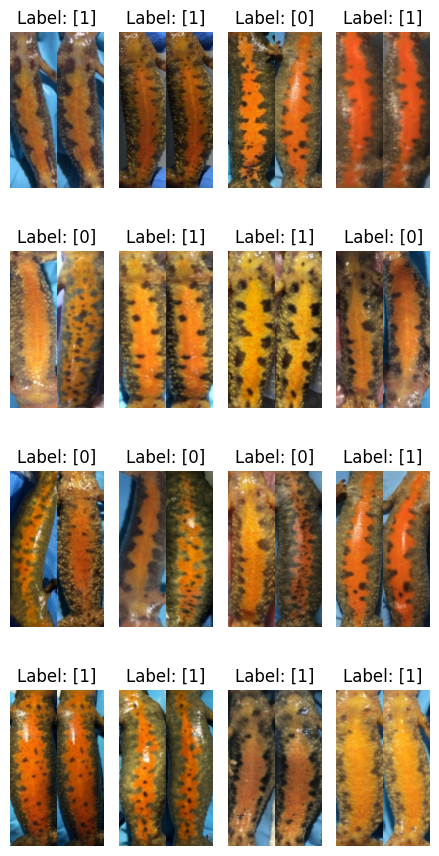

In [ ]:
visualize_pairs(Xpair_train[:-1], Ypair_train[:-1], to_show=16, num_col=4)

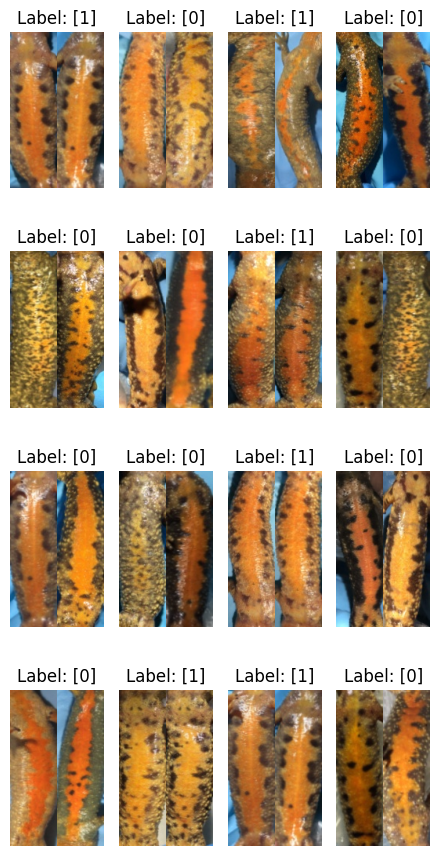

In [ ]:
visualize_pairs(Xpair_val[:-1], Ypair_val[:-1], to_show=16, num_col=4)

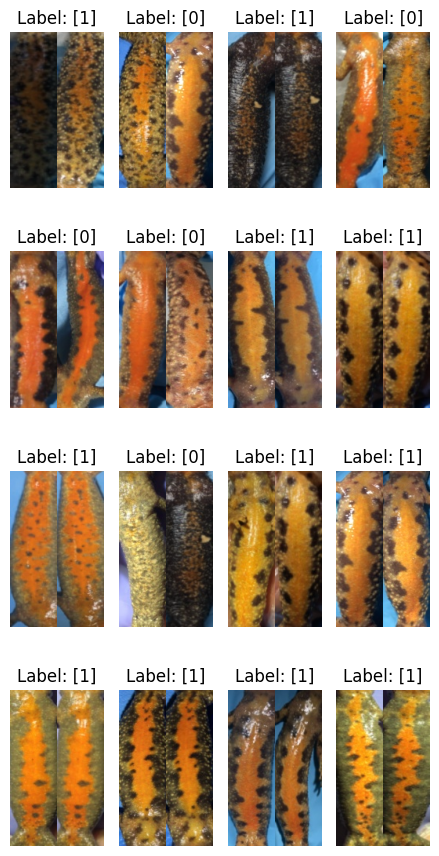

In [ ]:
visualize_pairs(Xpair_test[:-1], Ypair_test[:-1], to_show=16, num_col=4)

### Siamese Network Structure

Structure based on a paper for alphabet recognition

In [ ]:
# def W_init(shape, name=None):
#     """Initialize weights"""
#     values = rng.normal(loc=0, scale=1e-2, size=shape)
#     return K.variable(values, name=name)

# def b_init(shape, name=None):
#     """Initialize bias"""
#     values = rng.normal(loc=0.5, scale=1e-2, size=shape)
#     return K.variable(values, name=name)

input_shape=(200, 60, 3)
left_input=Input(input_shape)
right_input=Input(input_shape)

# built a CNN to use in each siamese "leg"
model = Sequential()
model.add(Conv2D(32, (3, 3),
                activation='relu',
                input_shape=input_shape,
                # kernel_initializer=W_init,
                kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3),
                 activation='relu',
                #  bias_initializer=b_init,
                #  kernel_initializer=W_init,
                 kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3),
                 activation='relu',
                #  bias_initializer=b_init,
                #  kernel_initializer=W_init,
                 kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3),
                 activation='relu',
                #  bias_initializer=b_init,
                #  kernel_initializer=W_init,
                 kernel_regularizer=l2(2e-4)))
model.add(Flatten())
model.add(Dense(311, activation='sigmoid',
                # bias_initializer=b_init,
                # kernel_initializer=W_init,
                kernel_regularizer=l2(1e-3)))

encoded_l=model(left_input)
encoded_r=model(right_input)

# We use the L1 distance
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
# pred = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
pred = Dense(1, activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input, right_input], outputs=pred)

optimizer = Adam(0.00006)

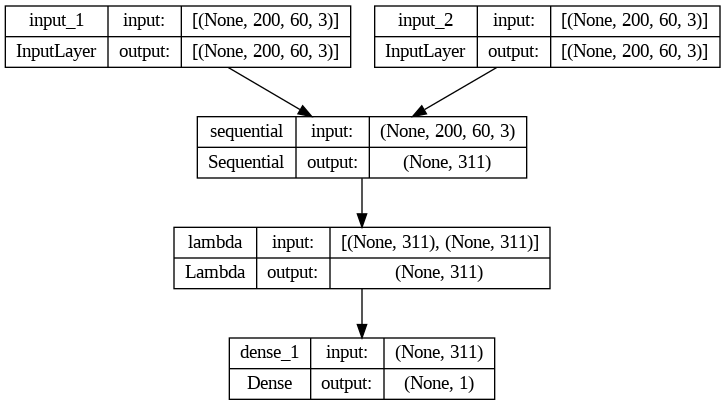

In [ ]:
from keras.utils import plot_model
plot_model(siamese_net, to_file='NotReallySiamese.png', show_shapes=True)

We define a function for the computation of the contrastive loss function (in the literature is highly recommendated instead of crossentropy binary loss)

In [ ]:
# def contrastive_loss(y_true, y_pred):
#     y_true_float = K.cast(y_true, dtype=tf.float32)
#     margin = K.constant(1.0, dtype=y_pred.dtype)
#     square_pred = K.square(y_pred)
#     margin_square = K.square(K.maximum(margin - y_pred, 0))
#     return K.mean((1 - y_true_float) * square_pred + y_true_float * margin_square)

Define function to plot the metrics of the network

In [ ]:
def metrics_plot(mod_cnn):
  fig, axs = plt.subplots(2, 2)
  # Accurary
  axs[0, 0].plot(mod_cnn.history['auc'])
  axs[0, 0].plot(mod_cnn.history['val_auc'])
  axs[0, 0].set(ylabel='AUC')
  # axs[0, 0].xlabel('epoch')

  # Loss
  axs[0, 1].plot(mod_cnn.history['loss'])
  axs[0, 1].plot(mod_cnn.history['val_loss'])
  axs[0, 1].set(ylabel='Constrastive Loss')
  # axs[0, 1].xlabel('epoch')

  # Precission
  axs[1, 0].plot(mod_cnn.history['precision'])
  axs[1, 0].plot(mod_cnn.history['val_precision'])
  axs[1, 0].set(ylabel='Precision')
  # axs[1, 0].xlabel('epoch')

  # Recall
  axs[1, 1].plot(mod_cnn.history['recall'])
  axs[1, 1].plot(mod_cnn.history['val_recall'])
  axs[1, 1].set(ylabel='Recall')
  # axs[1, 1].xlabel('epoch')

  plt.figlegend(['train', 'test'], loc='lower center', ncol=2)
  plt.show()

Compile the Siamese Network

In [ ]:
siamese_net.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizer,
                    metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 60, 3)]         0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 200, 60, 3)]         0         []                            
                                                                                                  
 sequential (Sequential)     (None, 311)                  5496759   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 311)                  0         ['sequential[0][0]',      

Correct image size

In [ ]:
Xpair_train = Xpair_train/256.0
Xpair_val = Xpair_val/256.0
Xpair_test = Xpair_test/256.0

Apply SNN structure to training and validation data

In [ ]:
history = siamese_net.fit(
    x=[Xpair_train[:,0], Xpair_train[:,1]],
    y=Ypair_train[:],
    epochs=30,
    batch_size=16,
    validation_data = ([Xpair_val[:, 0], Xpair_val[:, 1]], Ypair_val)
    )

Epoch 1/30
117/117 [==============================] - 183s 2s/step - loss: 1.1380 - auc: 0.6880 - precision: 0.7188 - recall: 0.0491 - val_loss: 0.9637 - val_auc: 0.7888 - val_precision: 0.6667 - val_recall: 0.0063
Epoch 2/30
117/117 [==============================] - 150s 1s/step - loss: 0.8380 - auc: 0.8519 - precision: 0.8365 - recall: 0.0929 - val_loss: 0.7815 - val_auc: 0.8239 - val_precision: 0.7159 - val_recall: 0.1975
Epoch 3/30
117/117 [==============================] - 141s 1s/step - loss: 0.7069 - auc: 0.8646 - precision: 0.8212 - recall: 0.3483 - val_loss: 0.7017 - val_auc: 0.8447 - val_precision: 0.8264 - val_recall: 0.3730
Epoch 4/30
117/117 [==============================] - 148s 1s/step - loss: 0.6395 - auc: 0.8656 - precision: 0.8179 - recall: 0.5662 - val_loss: 0.6752 - val_auc: 0.8271 - val_precision: 0.7803 - val_recall: 0.4232
Epoch 5/30
117/117 [==============================] - 139s 1s/step - loss: 0.5872 - auc: 0.8842 - precision: 0.8418 - recall: 0.6763 - val_l

See the results

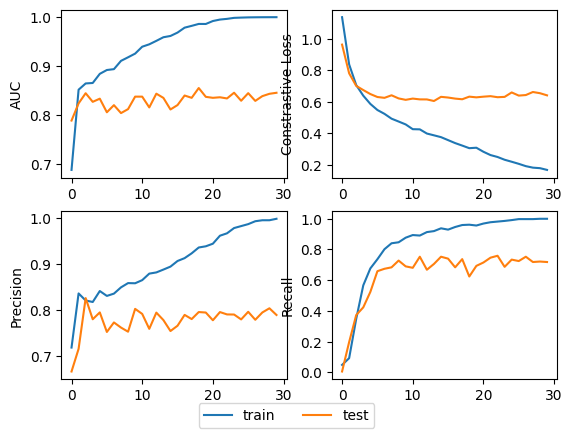

In [ ]:
metrics_plot(history)

Validate the model with the testing set

In [ ]:
res_siamese = siamese_net.evaluate([Xpair_test[:,0], Xpair_test[:,1]], Ypair_test)
print("Test loss and test auc:", res_siamese)

20/20 [==============================] - 14s 625ms/step - loss: 0.4864 - auc: 0.8974 - precision: 0.8203 - recall: 0.8230
Test loss and test auc: [0.48642513155937195, 0.8973824381828308, 0.8202614188194275, 0.8229508399963379]


Make predictions

In [ ]:
pred_siamese = siamese_net.predict([Xpair_test[:, 0], Xpair_test[:, 1]])

20/20 [==============================] - 16s 806ms/step


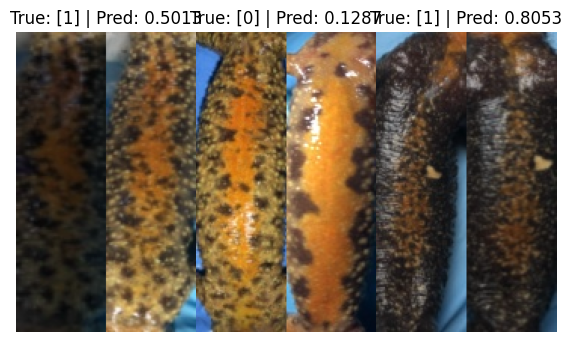

In [ ]:
visualize_pairs(Xpair_test, Ypair_test, to_show=3, predictions=pred_siamese, test=True)

In [ ]:
res_pred_siamese = pd.DataFrame({'Ytest' : np.concatenate(Ypair_test),
                            'Prob_prediction' : np.concatenate(pred_siamese)})

Search for the best threshold

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

def find_best_f1_score(y_true, y_prob):
    # Generate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # Calculate F1 score for different thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the threshold that maximizes F1 score
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Calculate F1 score using the best threshold
    best_f1_score = f1_score(y_true, y_prob >= best_threshold)

    return best_threshold, best_f1_score

best_threshold_siamese, best_f1_score_siamese = find_best_f1_score(Ypair_test, pred_siamese)

print(f"Best Threshold: {best_threshold_siamese}")
print(f"Best F1 Score: {best_f1_score_siamese}")

Best Threshold: 0.3088231384754181
Best F1 Score: 0.8597285067873304


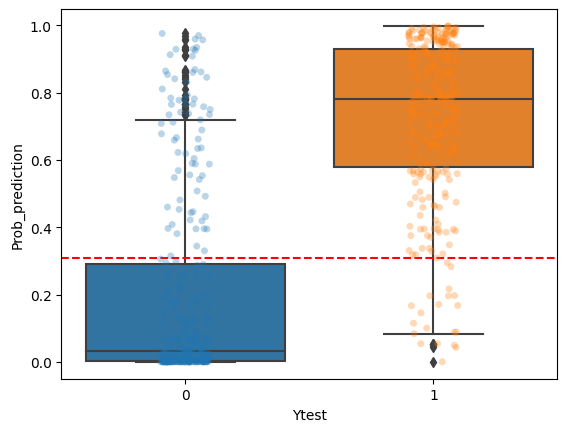

In [ ]:
import matplotlib as plt
import seaborn as sns

ax = sns.boxplot(x='Ytest', y='Prob_prediction', data=res_pred_siamese)
sns.stripplot(data=res_pred_siamese, y='Prob_prediction', x='Ytest', hue='Ytest',
              alpha=0.3, legend=False)
ax.axhline(y=best_threshold_siamese, color="red", linestyle="--", label=f'Best Threshold ({best_threshold_siamese:.2f})')

In [ ]:
res_pred_siamese['Prediction'] = np.where(res_pred_siamese['Prob_prediction'] >= best_threshold_siamese, 1, 0)
confusion_matrix(res_pred_siamese['Ytest'], res_pred_siamese['Prediction'])

array([[232,  73],
       [ 20, 285]])